In [1]:
import pandas as pd
import torch
import torch.nn as nn
from normalization import Input_output_data

df = pd.read_csv('Irregular-subnet/MSD/MSD_nonlinear_noisy_r_020.csv')

# Extract data
u = torch.tensor(df['Input'].values, dtype=torch.float32).view(-1, 1)  
y = torch.tensor(df['Output'].values, dtype=torch.float32).view(-1, 1)  
delta_t = torch.tensor(df['Delta_t'].values, dtype=torch.float32).view(-1, 1)  

# For test below
state_cols = [c for c in df.columns if c.startswith('TrueState_')]
x = torch.tensor(df[state_cols].values, dtype=torch.float32)   # (N , nx)

print(u.shape, y.shape, delta_t.shape, x.shape)  
data = Input_output_data(u, y, delta_t, x=x, name='irregular_sampling')

# Split dataset
train, val, test  = data[:10000], data[10000:12000], data[12000:]



print(f'{train = }')
print(f'{val = }')
print(f'{test = }')



torch.Size([19619, 1]) torch.Size([19619, 1]) torch.Size([19619, 1]) torch.Size([19619, 0])
train = Input_output_data "irregular_sampling" u.shape=torch.Size([10000, 1]), y.shape=torch.Size([10000, 1]), sampling_time varying, length=10000
val = Input_output_data "irregular_sampling" u.shape=torch.Size([2000, 1]), y.shape=torch.Size([2000, 1]), sampling_time varying, length=2000
test = Input_output_data "irregular_sampling" u.shape=torch.Size([7619, 1]), y.shape=torch.Size([7619, 1]), sampling_time varying, length=7619


In [2]:
std_delta_t = torch.std(delta_t)
var_delta_t = torch.var(delta_t)

print(f"Standard deviation of Delta_t: {std_delta_t.item()}")
print(f"Variance of Delta_t: {var_delta_t.item()}")


Standard deviation of Delta_t: 0.18853269517421722
Variance of Delta_t: 0.03554457426071167


Number of samples to train on = 9946


  0%|          | 0/30000 [00:00<?, ?it/s]

it       0 NRMS loss nan NRMS val nan   nan samps/sec
it     100 NRMS loss 1.58790 NRMS val 0.78602!! 236.80 samps/sec
it     200 NRMS loss 0.82953 NRMS val 0.76591!! 237.40 samps/sec
it     300 NRMS loss 0.79073 NRMS val 0.69539!! 237.74 samps/sec
it     400 NRMS loss 0.62456 NRMS val 0.42936!! 237.69 samps/sec
it     500 NRMS loss 0.47995 NRMS val 0.37297!! 237.71 samps/sec
it     600 NRMS loss 0.44454 NRMS val 0.34188!! 237.85 samps/sec
it     700 NRMS loss 0.41253 NRMS val 0.32076!! 237.82 samps/sec
it     800 NRMS loss 0.38590 NRMS val 0.30027!! 237.85 samps/sec
it     900 NRMS loss 0.36361 NRMS val 0.27892!! 237.69 samps/sec
it   1,000 NRMS loss 0.34741 NRMS val 0.26131!! 237.58 samps/sec
it   1,100 NRMS loss 0.33294 NRMS val 0.24952!! 237.57 samps/sec
it   1,200 NRMS loss 0.32271 NRMS val 0.24280!! 237.53 samps/sec
it   1,300 NRMS loss 0.31346 NRMS val 0.23199!! 237.50 samps/sec
it   1,400 NRMS loss 0.30698 NRMS val 0.22960!! 237.49 samps/sec
it   1,500 NRMS loss 0.30000 NRMS va

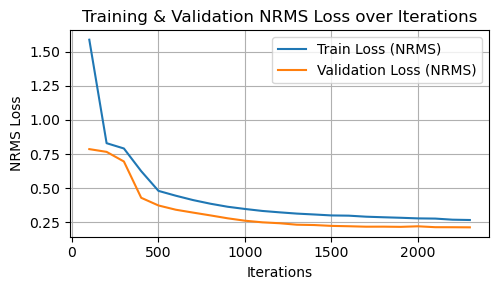

In [3]:

from normalization import get_nu_ny_and_auto_norm
from models import SUBNET_ISTS
from networks import rk4_integrator

nu, ny, norm = get_nu_ny_and_auto_norm(train)

torch.manual_seed(1)
model = SUBNET_ISTS(nu, ny, norm, nx=2, na=5, nb=5, integrator=rk4_integrator)
from fitting import fit
train_dict = fit(model, train=train, val=val, n_its=30000, T=50, batch_size=64, val_freq=100)


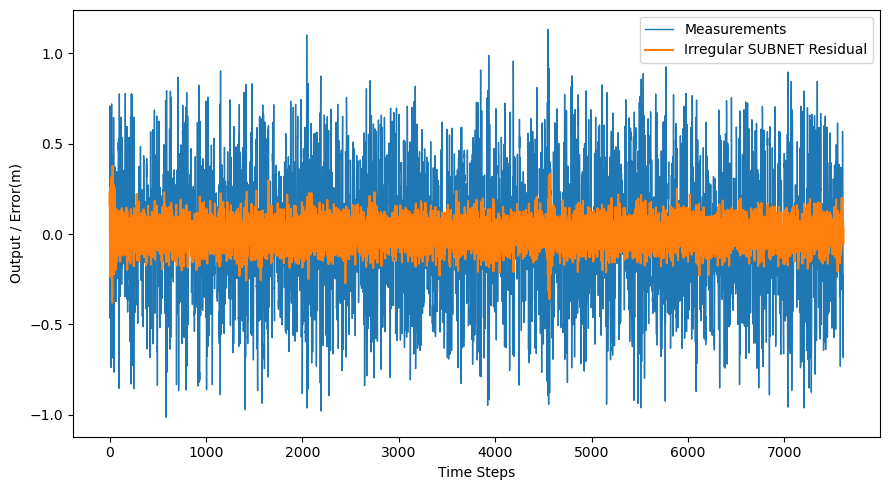

NRMS = 21.44%
RMSE = 0.0745 m


In [4]:
from matplotlib import pyplot as plt

test_sim = model.simulate(test)
y_true = test.y[model.na:]
y_pred = test_sim.y[model.na:]

if hasattr(y_true, 'detach'):
    y_true = y_true.detach().cpu().numpy()
if hasattr(y_pred, 'detach'):
    y_pred = y_pred.detach().cpu().numpy()

residual = y_true - y_pred

plt.figure(figsize=(9, 5))
# plt.plot(y_pred, label='Irregular SUBNET model',linewidth=1.5)
plt.plot(y_true, label='Measurements', linewidth=1)
plt.plot(residual, label='Irregular SUBNET Residual', linewidth=1.5)

# plt.title('True vs Predicted with Residual')
plt.xlabel('Time Steps')
plt.ylabel('Output / Error(m)')
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()

from nonlinear_benchmarks.error_metrics import NRMSE, RMSE
print(f'NRMS = {NRMSE(y_true, y_pred)[0]:.2%}')
print(f'RMSE = {RMSE(y_true, y_pred)[0]:.4f} m')


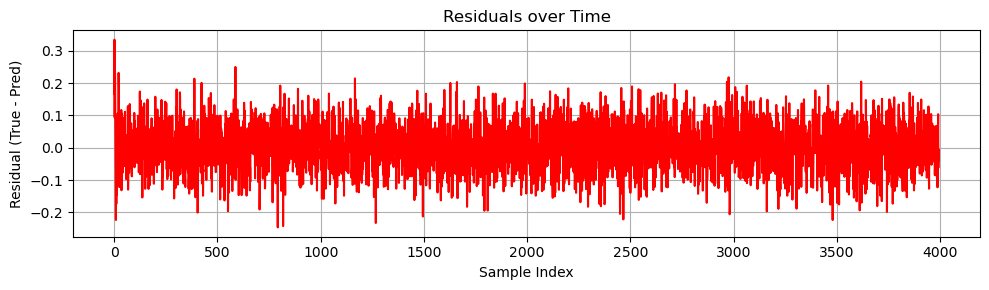

In [ ]:
residuals = y_true - y_pred
plt.figure(figsize=(10, 3))
plt.plot(residuals, color='red')
plt.title('Residuals over Time')
plt.xlabel('Sample Index')
plt.ylabel('Residual (True - Pred)')
plt.grid(True)
plt.tight_layout()
plt.show()


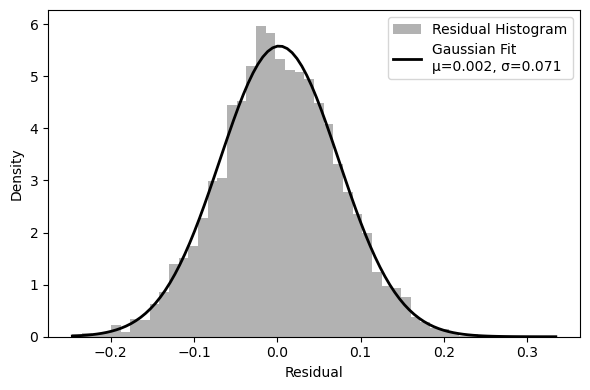

In [ ]:
import numpy as np
from scipy.stats import norm

mu, sigma = norm.fit(residuals)
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=50, density=True, alpha=0.6, color='gray', label='Residual Histogram')
x_vals = np.linspace(residuals.min(), residuals.max(), 100)
plt.plot(x_vals, norm.pdf(x_vals, mu, sigma), 'k', linewidth=2, label=f'Gaussian Fit\nμ={mu:.3f}, σ={sigma:.3f}')
# plt.title('Residual Histogram with Gaussian Fit')
plt.xlabel('Residual')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()


sampling time: $\Delta t = 0.3 + 0.2\cdot N(0,1)$

The test set is 4000 length.

| method         | noise ratio (%) | NRMS (%) | RMSE (m) |
| :--------------- | :----------- | :------- | :------- |
| **Irregular Subnet** |              |          |          |
|                  | 0            | 3.52 | 0.0114 |
|                  | 5            | 7.29     | 0.0248   |
|                  | 10           | 10.88    | 0.0370   |
|                  | 15           | 16.44    | 0.0549   |
|                  | 20           | 21.44    | 0.0745   |